# Station embeddings

In [28]:
import io
import os
import re
import time
import pickle
import collections

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [633]:
from adjustText import adjust_text
from sklearn.manifold import TSNE

In [336]:
# Set month
month = 'Oktober'

# Set index
imonth = '10'

In [545]:
# Step 1: Load station diaries
Diaries = []
directory = 'data/istdaten/{}/diaries/'.format(month)
files = os.listdir(directory)
for file in sorted(files):
    path = '{}{}'.format(directory, file)
    d = pd.read_pickle(path)
    Diaries.append(d)

In [547]:
# 'PAD' is used to separate routes from each other
words = []
for diary in Diaries:
    for row in diary.values:
        words.append('PAD')
        words.append('PAD')
        route = [x for x in row if x != None]
        stops = [item for sublist in route for item in sublist]
        for stop in stops:
            if '=>' not in stop:
                words.append(stop)
        words.append('PAD')
        words.append('PAD')

In [548]:
# Reduce memory
del Diaries

In [551]:
# Step 2: Build the dictionary and replace rare words with UNK token.
# Here the vocabulary equals unique stations but can be also less
vocabulary_size = len(np.unique(words))

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

In [552]:
data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0

Most common words (+UNK) [['UNK', 1], ('PAD', 1282820), ('Zürich HB', 161478), ('Bern', 116191), ('Basel SBB', 60648)]
Sample data [1, 1, 4, 145, 1, 1, 1, 1, 68, 2] ['PAD', 'PAD', 'Basel SBB', 'Basel Bad Bf', 'PAD', 'PAD', 'PAD', 'PAD', 'Schaffhausen', 'Zürich HB']


In [556]:
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [557]:
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

1 PAD -> 1 PAD
1 PAD -> 4 Basel SBB
4 Basel SBB -> 1 PAD
4 Basel SBB -> 145 Basel Bad Bf
145 Basel Bad Bf -> 1 PAD
145 Basel Bad Bf -> 4 Basel SBB
1 PAD -> 1 PAD
1 PAD -> 145 Basel Bad Bf


In [560]:
data_size = len(data)
data_size

6376428

In [563]:
# TRAINING PARAMETERS
batch_size = 32                                             # Number of training examples per batch
embedding_size = 128                                        # Dimension of embedding vectors
skip_window = 4                                             # Window size for context to the left and right of target
num_skips = 4                                               # How many times to reuse target to generate a label for context.
batches_per_epoch = int(data_size*num_skips/batch_size)     # Number of batches per epoch of training
training_epochs = 5                                         # Number of epochs to utilize for training
neg_size = 64                                               # Number of negative samples to use for NCE
display_step = 2000                                         # Frequency with which to print statistics
val_step = 10000                                            # Frequency with which to perform validation
learning_rate = 0.1                                         # Learning rate for SGD

In [564]:
print("Epochs: %d, Batches per epoch: %d, Examples per batch: %d" % (
    training_epochs, batches_per_epoch, batch_size))

Epochs: 5, Batches per epoch: 797053, Examples per batch: 32


In [566]:
# NEAREST NEIGHBORS VALIDATION PARAMETERS
val_size = 20
val_dist_span = 500
val_examples = np.random.choice(val_dist_span, val_size, replace=False)
top_match = 5

In [567]:
def embedding_layer(x, embedding_shape):
    with tf.compat.v1.variable_scope("embedding"):
        embedding_init = tf.random.uniform(embedding_shape, -1.0, 1.0)
        embedding_matrix = tf.compat.v1.get_variable("E", initializer=embedding_init)
        return tf.nn.embedding_lookup(embedding_matrix, x), embedding_matrix

In [568]:
def noise_contrastive_loss(embedding_lookup, weight_shape, bias_shape, y):
    with tf.compat.v1.variable_scope("nce"):
        nce_weight_init = tf.random.truncated_normal(weight_shape, stddev=1.0/(weight_shape[1])**0.5)
        nce_bias_init = tf.zeros(bias_shape)
        nce_W = tf.compat.v1.get_variable("W", initializer=nce_weight_init)
        nce_b = tf.compat.v1.get_variable("b", initializer=nce_bias_init)

        total_loss = tf.compat.v1.nn.nce_loss(nce_W, nce_b, y, embedding_lookup, neg_size, vocabulary_size)
        return tf.reduce_mean(total_loss)

In [569]:
def training(cost, global_step):
    with tf.compat.v1.variable_scope("training"):
        summary_op = tf.compat.v1.summary.scalar("cost", cost)
        optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate)
        train_op = optimizer.minimize(cost, global_step=global_step)
        return train_op, summary_op

In [570]:
def validation(embedding_matrix, x_val):
    norm = tf.math.reduce_sum(embedding_matrix**2, 1, keepdims=True)**0.5
    normalized = embedding_matrix/norm
    val_embeddings = tf.nn.embedding_lookup(normalized, x_val)
    cosine_similarity = tf.linalg.matmul(val_embeddings, normalized, transpose_b=True)
    return normalized, cosine_similarity

In [571]:
with tf.Graph().as_default():

    with tf.compat.v1.variable_scope("skipgram_model"):

        x = tf.compat.v1.placeholder(tf.int32, shape=[batch_size])
        y = tf.compat.v1.placeholder(tf.int32, [batch_size, 1])
        val = tf.constant(val_examples, dtype=tf.int32)
        global_step = tf.Variable(0, name='global_step', trainable=False)

        e_lookup, e_matrix = embedding_layer(x, [vocabulary_size, embedding_size])
        
        cost = noise_contrastive_loss(
            e_lookup, [vocabulary_size, embedding_size], [vocabulary_size], y)
        
        train_op, summary_op = training(cost, global_step)
        
        val_op = validation(e_matrix, val)

        sess = tf.compat.v1.Session()

        train_writer = tf.compat.v1.summary.FileWriter("word_embedding_logs/", graph=sess.graph)

        init_op = tf.compat.v1.global_variables_initializer()

        sess.run(init_op)

        step = 0
        avg_cost = 0
        
        # Training cycle
        for epoch in range(training_epochs):
            for minibatch in range(batches_per_epoch):

                step +=1

                minibatch_x, minibatch_y = generate_batch(batch_size, num_skips, skip_window)
                feed_dict = {x : minibatch_x, y : minibatch_y}
            
                _, new_cost, train_summary = sess.run([train_op, cost, summary_op], feed_dict=feed_dict)
                train_writer.add_summary(train_summary, sess.run(global_step))
                # Compute average loss
                avg_cost += new_cost/display_step
                
                if step % display_step == 0:
                    print("Elapsed:", str(step), "batches. Cost =", "{:.9f}".format(avg_cost))
                    avg_cost = 0
                
                if step % val_step == 0:
                    _, similarity = sess.run(val_op)
                    for i in range(val_size):
                        val_word = reverse_dictionary[val_examples[i]]
                        neighbors = (-similarity[i, :]).argsort()[1:top_match+1]
                        print_str = "Nearest neighbor of %s:" % val_word
                        for k in range(top_match):
                            print_str += " %s," % reverse_dictionary[neighbors[k]]
                        print(print_str[:-1])
   

        final_embeddings, _ = sess.run(val_op)

Elapsed: 2000 batches. Cost = 13.144043445
Elapsed: 4000 batches. Cost = 5.015790467
Elapsed: 6000 batches. Cost = 4.395417294
Elapsed: 8000 batches. Cost = 5.006718279
Elapsed: 10000 batches. Cost = 5.409725514
Nearest neighbor of Kehrsatz Nord: Pratteln, Schwerzenbach ZH, Tecknau, Dompierre, Aigle
Nearest neighbor of St-Imier: Winterthur Töss, Genève-Sécheron, Hinwil, Delémont, Wangen an der Aare
Nearest neighbor of Fleurier: Delémont, Spiez, Moutier, Burgdorf Steinhof, Clarens
Nearest neighbor of Bern Stöckacker: Gelfingen, Dulliken, Zürich Wipkingen, Regensdorf-Watt, Uetikon
Nearest neighbor of Goldach: Route de Morgins, Renan BE, Neyruz, Jona, Langenthal
Nearest neighbor of Grolley: Yverdon-Champ Pittet, Ziegelbrücke, Dübendorf, Möhlin, Olten
Nearest neighbor of Grafenried: Weissenburg, Kehrsatz, Bernina Suot, Faido, Lancy-Bachet
Nearest neighbor of Tobel-Affeltrangen: Gümligen, Martigny, Kempraten, Willisau, Spiez
Nearest neighbor of Schwerzenbach ZH: St. Margrethen, Wetzikon, Ne

Elapsed: 42000 batches. Cost = 2.237210034
Elapsed: 44000 batches. Cost = 2.339648863
Elapsed: 46000 batches. Cost = 2.157066675
Elapsed: 48000 batches. Cost = 2.016961598
Elapsed: 50000 batches. Cost = 2.234173163
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Altstätten SG, Schwerzenbach ZH, Zug Chollermüli, Pratteln
Nearest neighbor of St-Imier: Winterthur Töss, Hinwil, Vechigen, Genève-Sécheron, Wangen an der Aare
Nearest neighbor of Fleurier: Burgdorf Steinhof, Clarens, Signau, Dallenwil, Hinwil
Nearest neighbor of Bern Stöckacker: Gelfingen, Dulliken, Alpnachstad, Les Marches, Zürich Wipkingen
Nearest neighbor of Goldach: Route de Morgins, Renan BE, Jona, Langenthal, Le Locle
Nearest neighbor of Grolley: Selzach, Olten, Schüpfen, Dübendorf, Luzern Verkehrshaus
Nearest neighbor of Grafenried: Kehrsatz, Zug Schutzengel, Baar Neufeld, Moosseedorf, Bern
Nearest neighbor of Tobel-Affeltrangen: Gümligen, Martigny, Massongex, Tannay, Kempraten
Nearest neighbor of Schwerzenbach ZH

Elapsed: 82000 batches. Cost = 1.933629137
Elapsed: 84000 batches. Cost = 1.882958571
Elapsed: 86000 batches. Cost = 2.067296044
Elapsed: 88000 batches. Cost = 2.183015604
Elapsed: 90000 batches. Cost = 2.063731030
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Altstätten SG, Schwerzenbach ZH, Zug Chollermüli, Pratteln
Nearest neighbor of St-Imier: Winterthur Töss, Hinwil, Vechigen, Genève-Sécheron, Wangen an der Aare
Nearest neighbor of Fleurier: Luzern, Clarens, Burgdorf Steinhof, Dallenwil, Signau
Nearest neighbor of Bern Stöckacker: Dulliken, Alpnachstad, Gelfingen, Les Marches, Zürich Wipkingen
Nearest neighbor of Goldach: Route de Morgins, Renan BE, Jona, Langenthal, St. Gallen St. Fiden
Nearest neighbor of Grolley: Selzach, Schüpfen, Olten, Luzern Verkehrshaus, Dübendorf
Nearest neighbor of Grafenried: Moosseedorf, Bern, Kehrsatz, Zug Schutzengel, Jegenstorf
Nearest neighbor of Tobel-Affeltrangen: Gümligen, Martigny, Massongex, Tannay, Kaiserstuhl OW
Nearest neighbor of S

Elapsed: 122000 batches. Cost = 1.942020404
Elapsed: 124000 batches. Cost = 2.062759612
Elapsed: 126000 batches. Cost = 2.077669802
Elapsed: 128000 batches. Cost = 2.155006498
Elapsed: 130000 batches. Cost = 1.939494248
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Altstätten SG, Zug Chollermüli, Schwerzenbach ZH, Pratteln
Nearest neighbor of St-Imier: Vechigen, Hinwil, Winterthur Töss, Wangen an der Aare, Genève-Sécheron
Nearest neighbor of Fleurier: Luzern, Clarens, Burgdorf Steinhof, Rhäzüns, Dallenwil
Nearest neighbor of Bern Stöckacker: Dulliken, Les Marches, Gelfingen, Alpnachstad, Zürich Wipkingen
Nearest neighbor of Goldach: Route de Morgins, Renan BE, St. Gallen St. Fiden, Jona, Langenthal
Nearest neighbor of Grolley: Selzach, Schüpfen, Olten, Luzern Verkehrshaus, Dübendorf
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Bern, Zug Schutzengel, Kehrsatz
Nearest neighbor of Tobel-Affeltrangen: Gümligen, Martigny, Oppikon, Kaiserstuhl OW, Tannay
Nearest neighbor 

Elapsed: 162000 batches. Cost = 2.175098206
Elapsed: 164000 batches. Cost = 1.949111270
Elapsed: 166000 batches. Cost = 1.765396978
Elapsed: 168000 batches. Cost = 1.717812482
Elapsed: 170000 batches. Cost = 2.080988048
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Altstätten SG, Wabern bei Bern, Zug Chollermüli, Pratteln
Nearest neighbor of St-Imier: Vechigen, Hinwil, Genève-Sécheron, La Chaux-de-Fonds, Wangen an der Aare
Nearest neighbor of Fleurier: Rhäzüns, Clarens, Dallenwil, Burgdorf Steinhof, Luzern
Nearest neighbor of Bern Stöckacker: Les Marches, Dulliken, Alpnachstad, Gelfingen, Zürich Wipkingen
Nearest neighbor of Goldach: Renan BE, Route de Morgins, St. Gallen St. Fiden, St. Gallen, Langenthal
Nearest neighbor of Grolley: Selzach, Schüpfen, Olten, Luzern Verkehrshaus, Luterbach-Attisholz
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Bern, Zug Schutzengel, Schönbühl RBS
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Martigny, Gümligen, Kaiserstuhl OW, Fa

Elapsed: 202000 batches. Cost = 1.828843724
Elapsed: 204000 batches. Cost = 1.631741231
Elapsed: 206000 batches. Cost = 1.970334786
Elapsed: 208000 batches. Cost = 2.146768426
Elapsed: 210000 batches. Cost = 1.977985518
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Wabern bei Bern, Altstätten SG, Schwerzenbach ZH, Kehrsatz
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Vechigen, Hinwil, Wangen an der Aare, Genève-Sécheron
Nearest neighbor of Fleurier: Luzern, Rhäzüns, Clarens, Môtiers, Burgdorf Steinhof
Nearest neighbor of Bern Stöckacker: Les Marches, Dulliken, Gelfingen, Alpnachstad, Zürich Wipkingen
Nearest neighbor of Goldach: Renan BE, Route de Morgins, St. Gallen St. Fiden, Jona, Langenthal
Nearest neighbor of Grolley: Selzach, Schüpfen, Olten, Luterbach-Attisholz, Luzern Verkehrshaus
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Zug Schutzengel, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Martigny, Gümligen, Kaiserstuhl OW, Fau

Elapsed: 242000 batches. Cost = 2.068402605
Elapsed: 244000 batches. Cost = 2.075354493
Elapsed: 246000 batches. Cost = 2.109609219
Elapsed: 248000 batches. Cost = 1.882175401
Elapsed: 250000 batches. Cost = 1.708022725
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Wabern bei Bern, Kehrsatz, Schwerzenbach ZH, Zug Chollermüli
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Hinwil, Vechigen, Wangen an der Aare, Genève-Sécheron
Nearest neighbor of Fleurier: Luzern, Rhäzüns, Môtiers, Clarens, Burgdorf Steinhof
Nearest neighbor of Bern Stöckacker: Les Marches, Dulliken, Gelfingen, Alpnachstad, Zürich Wipkingen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Route de Morgins, Renan BE, Jona, Langenthal
Nearest neighbor of Grolley: Selzach, Schüpfen, Luterbach-Attisholz, Corcelles-Sud, Luzern Verkehrshaus
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Zug Schutzengel, Pfungen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Martigny, Gümligen, Kaiserstuhl 

Elapsed: 282000 batches. Cost = 2.098519134
Elapsed: 284000 batches. Cost = 1.928616855
Elapsed: 286000 batches. Cost = 1.731120861
Elapsed: 288000 batches. Cost = 1.693458260
Elapsed: 290000 batches. Cost = 2.017063211
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Wabern bei Bern, Kehrsatz, Zug Chollermüli, Schwerzenbach ZH
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Hinwil, Vechigen, Bonaduz, Genève-Sécheron
Nearest neighbor of Fleurier: Môtiers, Rhäzüns, Clarens, Luzern, Burgdorf Steinhof
Nearest neighbor of Bern Stöckacker: Les Marches, Bern, Dulliken, Alpnachstad, Gelfingen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Route de Morgins, Renan BE, Mörschwil, Jona
Nearest neighbor of Grolley: Schüpfen, Selzach, Corcelles-Sud, Luterbach-Attisholz, Olten
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Zug Schutzengel, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Martigny, Gümligen, Kaiserstuhl OW, Faulensee
Nearest neighbor of Schw

Elapsed: 322000 batches. Cost = 1.770383727
Elapsed: 324000 batches. Cost = 1.657454524
Elapsed: 326000 batches. Cost = 1.911346493
Elapsed: 328000 batches. Cost = 2.095965249
Elapsed: 330000 batches. Cost = 1.996582661
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Wabern bei Bern, Kehrsatz, Schwerzenbach ZH, Zug Chollermüli
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Hinwil, Bonaduz, Vechigen, Wangen an der Aare
Nearest neighbor of Fleurier: Môtiers, Luzern, Rhäzüns, Clarens, Hochdorf Schönau
Nearest neighbor of Bern Stöckacker: Les Marches, Dulliken, Bern, Bern Bümpliz Nord, Alpnachstad
Nearest neighbor of Goldach: St. Gallen St. Fiden, Route de Morgins, Renan BE, Mörschwil, St. Gallen
Nearest neighbor of Grolley: Selzach, Schüpfen, Corcelles-Sud, Luterbach-Attisholz, Luzern Verkehrshaus
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Zug Schutzengel, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Martigny, Gümligen, Kaiserstuhl OW, Faul

Elapsed: 362000 batches. Cost = 1.662997576
Elapsed: 364000 batches. Cost = 1.984056521
Elapsed: 366000 batches. Cost = 2.111352552
Elapsed: 368000 batches. Cost = 2.022380245
Elapsed: 370000 batches. Cost = 1.987331177
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Wabern bei Bern, Kehrsatz, Schwerzenbach ZH, Zug Chollermüli
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Hinwil, Thalwil, Wangen an der Aare, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Rhäzüns, Luzern, Clarens, Reichenau-Tamins
Nearest neighbor of Bern Stöckacker: Les Marches, Dulliken, Bern Bümpliz Nord, Alpnachstad, Gelfingen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Route de Morgins, Renan BE, Mörschwil, Jona
Nearest neighbor of Grolley: Schüpfen, Selzach, Corcelles-Sud, Luterbach-Attisholz, Giubiasco
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Zug Schutzengel, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Martigny, Gümligen, Kaiserstuhl OW, Faulensee
Nearest 

Elapsed: 402000 batches. Cost = 2.017688980
Elapsed: 404000 batches. Cost = 2.051679130
Elapsed: 406000 batches. Cost = 2.034333801
Elapsed: 408000 batches. Cost = 1.850833537
Elapsed: 410000 batches. Cost = 1.681680940
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Wabern bei Bern, Kehrsatz, Schwerzenbach ZH, Belp
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Thalwil, Hinwil, Bonaduz, Wangen an der Aare
Nearest neighbor of Fleurier: Môtiers, Luzern, Rhäzüns, Clarens, Burgdorf Steinhof
Nearest neighbor of Bern Stöckacker: Les Marches, Bern Bümpliz Nord, Dulliken, Ittigen bei Bern, Pfungen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Route de Morgins, Mörschwil, Renan BE, Heerbrugg
Nearest neighbor of Grolley: Selzach, Schüpfen, Corcelles-Sud, Luterbach-Attisholz, Cousset
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Schönbühl RBS, Zürich HB
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Martigny, Märwil, Tägerschen, Faulensee
Nearest neighbor of Schw

Elapsed: 442000 batches. Cost = 2.051760619
Elapsed: 444000 batches. Cost = 2.002268368
Elapsed: 446000 batches. Cost = 1.727644656
Elapsed: 448000 batches. Cost = 1.722700261
Elapsed: 450000 batches. Cost = 2.053319385
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Wabern bei Bern, Kehrsatz, Schwerzenbach ZH, Belp
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Hinwil, Thalwil, Bonaduz, Wangen an der Aare
Nearest neighbor of Fleurier: Môtiers, Rhäzüns, Clarens, Biasca, Hochdorf Schönau
Nearest neighbor of Bern Stöckacker: Les Marches, Bern Bümpliz Nord, Dulliken, Zürich Wipkingen, Gelfingen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Route de Morgins, Mörschwil, Renan BE, Rorschach Stadt
Nearest neighbor of Grolley: Schüpfen, Selzach, Corcelles-Sud, Luterbach-Attisholz, Cousset
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Peist, Schönbühl RBS, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Martigny, Märwil, Tägerschen, Faulensee
Nearest neighbor of

Elapsed: 482000 batches. Cost = 1.663509041
Elapsed: 484000 batches. Cost = 1.689002704
Elapsed: 486000 batches. Cost = 2.024131488
Elapsed: 488000 batches. Cost = 2.110841883
Elapsed: 490000 batches. Cost = 2.025812657
Nearest neighbor of Kehrsatz Nord: Bern  Europaplatz, Wabern bei Bern, Kehrsatz, Belp, Schwerzenbach ZH
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Thalwil, Hinwil, Bonaduz, Courtelary
Nearest neighbor of Fleurier: Môtiers, Rhäzüns, Biasca, Luzern, Clarens
Nearest neighbor of Bern Stöckacker: Les Marches, Bern Bümpliz Nord, Dulliken, Zürich Wipkingen, Gelfingen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Route de Morgins, Heerbrugg, Rorschach Stadt
Nearest neighbor of Grolley: Selzach, Schüpfen, Corcelles-Sud, Luterbach-Attisholz, Payerne
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Peist, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Martigny, Märwil, Tägerschen, Kaiserstuhl OW
Nearest neighbor of Schwerzenba

Elapsed: 522000 batches. Cost = 2.060071325
Elapsed: 524000 batches. Cost = 2.083930006
Elapsed: 526000 batches. Cost = 2.129067608
Elapsed: 528000 batches. Cost = 1.868920729
Elapsed: 530000 batches. Cost = 1.669661962
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern  Europaplatz, Kehrsatz, Belp, Schwerzenbach ZH
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Thalwil, Hinwil, Bonaduz, Courtelary
Nearest neighbor of Fleurier: Môtiers, Rhäzüns, Luzern, Biasca, Clarens
Nearest neighbor of Bern Stöckacker: Les Marches, Bern Bümpliz Nord, Dulliken, Rosshäusern, Zürich Wipkingen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Route de Morgins, Rorschach Stadt, Heerbrugg
Nearest neighbor of Grolley: Corcelles-Sud, Selzach, Schüpfen, Luterbach-Attisholz, Cousset
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Peist, Zürich HB
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Martigny, Märwil, Tägerschen, Kaiserstuhl OW
Nearest neighbor of Schwerz

Elapsed: 562000 batches. Cost = 2.102942314
Elapsed: 564000 batches. Cost = 1.915449306
Elapsed: 566000 batches. Cost = 1.645933824
Elapsed: 568000 batches. Cost = 1.727702549
Elapsed: 570000 batches. Cost = 2.037674961
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern  Europaplatz, Kehrsatz, Belp, Zug Chollermüli
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Hinwil, Thalwil, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Rhäzüns, Biasca, Couvet, Clarens
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Dulliken, Bern, Rosshäusern
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Route de Morgins, Rorschach Stadt, Heerbrugg
Nearest neighbor of Grolley: Corcelles-Sud, Schüpfen, Selzach, Payerne, Luterbach-Attisholz
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Peist, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Martigny, Tägerschen, Kaiserstuhl OW
Nearest neighbor of Schwerzenbach ZH: W

Elapsed: 602000 batches. Cost = 1.671309324
Elapsed: 604000 batches. Cost = 1.787891735
Elapsed: 606000 batches. Cost = 2.033123006
Elapsed: 608000 batches. Cost = 1.997869151
Elapsed: 610000 batches. Cost = 2.130073796
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Schwerzenbach ZH
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Thalwil, Hinwil, Courtelary, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Rhäzüns, Biasca, Couvet, Luzern
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Bern, Dulliken, Rosshäusern
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Route de Morgins, Rorschach Stadt, Heerbrugg
Nearest neighbor of Grolley: Schüpfen, Corcelles-Sud, Selzach, Luterbach-Attisholz, Cousset
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Peist, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Martigny, Tägerschen, Bettwiesen
Nearest neighbor of Schwerzenbach ZH: Wetzikon

Elapsed: 642000 batches. Cost = 2.036972920
Elapsed: 644000 batches. Cost = 2.001727984
Elapsed: 646000 batches. Cost = 2.113457349
Elapsed: 648000 batches. Cost = 1.789374871
Elapsed: 650000 batches. Cost = 1.653866876
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern  Europaplatz, Kehrsatz, Belp, Zug Chollermüli
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Thalwil, Courtelary, Hinwil, Sonvilier
Nearest neighbor of Fleurier: Môtiers, Rhäzüns, Biasca, Couvet, Luzern
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Dulliken, Rosshäusern, Bern
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Route de Morgins, Rorschach Stadt, Heerbrugg
Nearest neighbor of Grolley: Corcelles-Sud, Schüpfen, Selzach, Payerne, Luterbach-Attisholz
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Peist, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Martigny, Bettwiesen
Nearest neighbor of Schwerzenbach ZH: Wetziko

Elapsed: 682000 batches. Cost = 2.096449219
Elapsed: 684000 batches. Cost = 1.881907580
Elapsed: 686000 batches. Cost = 1.687567636
Elapsed: 688000 batches. Cost = 1.683573570
Elapsed: 690000 batches. Cost = 2.086990211
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Hinwil, Sonvilier, Thalwil
Nearest neighbor of Fleurier: Môtiers, Rhäzüns, Biasca, Couvet, Clarens
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Bern, Rosshäusern, Dulliken
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Route de Morgins, Rorschach Stadt, Heerbrugg
Nearest neighbor of Grolley: Corcelles-Sud, Payerne, Schüpfen, Selzach, Luterbach-Attisholz
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Peist, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Martigny, Bettwiesen
Nearest neighbor of Schwerzenbach ZH: Wetzikon,

Elapsed: 722000 batches. Cost = 1.720303326
Elapsed: 724000 batches. Cost = 1.573884360
Elapsed: 726000 batches. Cost = 1.882166195
Elapsed: 728000 batches. Cost = 2.025393288
Elapsed: 730000 batches. Cost = 1.995845463
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Hinwil, Sonvilier, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Rhäzüns, Biasca, Couvet, Clarens
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Rosshäusern, Dulliken, Bern
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Rorschach
Nearest neighbor of Grolley: Payerne, Corcelles-Sud, Schüpfen, Luterbach-Attisholz, Cousset
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Peist, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Martigny, Kaiserstuhl OW
Nearest neighbor of Schwerzenbach ZH: Wetzi

Elapsed: 762000 batches. Cost = 1.688687673
Elapsed: 764000 batches. Cost = 2.076886023
Elapsed: 766000 batches. Cost = 2.075684299
Elapsed: 768000 batches. Cost = 1.957133868
Elapsed: 770000 batches. Cost = 1.964588116
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Hinwil, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Rhäzüns, Biasca, Couvet, Clarens
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Rosshäusern, Dulliken, Alpnachstad
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Heerbrugg
Nearest neighbor of Grolley: Corcelles-Sud, Schüpfen, Payerne, Luterbach-Attisholz, Belfaux CFF
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Schönbühl RBS, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Martigny, Bettwiesen
Nearest neighbor of Schwerzenbach ZH: Wetz

Elapsed: 802000 batches. Cost = 2.030602333
Elapsed: 804000 batches. Cost = 2.023406796
Elapsed: 806000 batches. Cost = 2.075718474
Elapsed: 808000 batches. Cost = 1.827435091
Elapsed: 810000 batches. Cost = 1.674749829
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Hinwil, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Rhäzüns, Clarens
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Rosshäusern, Dulliken, Bern Brünnen Westside
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Heerbrugg
Nearest neighbor of Grolley: Corcelles-Sud, Schüpfen, Cousset, Belfaux CFF, Luterbach-Attisholz
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Peist, Schönbühl RBS, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Martigny, Bettwiesen
Nearest neighbor of Schwer

Elapsed: 842000 batches. Cost = 2.058002120
Elapsed: 844000 batches. Cost = 1.773048231
Elapsed: 846000 batches. Cost = 1.634659236
Elapsed: 848000 batches. Cost = 1.862747014
Elapsed: 850000 batches. Cost = 2.054037067
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Hinwil, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Rhäzüns, Clarens
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Rosshäusern, Dulliken, Bern Brünnen Westside
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Heerbrugg
Nearest neighbor of Grolley: Payerne, Corcelles-Sud, Schüpfen, PAD, Belfaux CFF
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Peist, Schönbühl RBS, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nearest neighbor of Schwerzenbach ZH: W

Elapsed: 882000 batches. Cost = 1.662739274
Elapsed: 884000 batches. Cost = 1.719645660
Elapsed: 886000 batches. Cost = 2.046133486
Elapsed: 888000 batches. Cost = 2.027771225
Elapsed: 890000 batches. Cost = 2.098050388
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern  Europaplatz, Kehrsatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Hinwil, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Rhäzüns, Buchs SG
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Rosshäusern, Bern Brünnen Westside, Dulliken
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Heerbrugg
Nearest neighbor of Grolley: Payerne, Corcelles-Sud, Schüpfen, Belfaux CFF, Givisiez
Nearest neighbor of Grafenried: Moosseedorf, Jegenstorf, Schönbühl RBS, Peist, Bern
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nearest neighbor of Schwerzenbach ZH: D

Elapsed: 922000 batches. Cost = 2.092184260
Elapsed: 924000 batches. Cost = 2.006777851
Elapsed: 926000 batches. Cost = 1.901326824
Elapsed: 928000 batches. Cost = 1.719753728
Elapsed: 930000 batches. Cost = 1.647074292
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Hinwil, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Couvet, Rhäzüns, Biasca, Clarens
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Rosshäusern, Bern Brünnen Westside, Dulliken
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Heerbrugg
Nearest neighbor of Grolley: Payerne, Corcelles-Sud, Belfaux CFF, Cousset, Schüpfen
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Schönbühl RBS, Peist, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Saanen
Nearest neighbor of Schwerzenbach ZH: Düben

Elapsed: 962000 batches. Cost = 2.078629752
Elapsed: 964000 batches. Cost = 1.747984487
Elapsed: 966000 batches. Cost = 1.606782857
Elapsed: 968000 batches. Cost = 1.906467439
Elapsed: 970000 batches. Cost = 2.023821147
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Bonaduz, Hinwil
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Rhäzüns, Clarens
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Rosshäusern, Bern Brünnen Westside, Bern
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Rorschach
Nearest neighbor of Grolley: Payerne, Corcelles-Sud, Belfaux CFF, Schüpfen, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Schönbühl RBS, Zollikofen, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Saanen
Nearest neighbor of Schwerzenbach ZH: Dübendor

Elapsed: 1002000 batches. Cost = 1.635366654
Elapsed: 1004000 batches. Cost = 2.024934353
Elapsed: 1006000 batches. Cost = 2.110102665
Elapsed: 1008000 batches. Cost = 2.124996470
Elapsed: 1010000 batches. Cost = 1.817837449
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Bonaduz, Hinwil
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Rhäzüns, Buchs SG
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern, Les Marches, Bern Brünnen Westside
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Rorschach
Nearest neighbor of Grolley: Payerne, Corcelles-Sud, Belfaux CFF, Givisiez, Schüpfen
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Schönbühl RBS, Peist, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nearest neighbor of Schwerzenbac

Elapsed: 1042000 batches. Cost = 2.129997857
Elapsed: 1044000 batches. Cost = 1.955584910
Elapsed: 1046000 batches. Cost = 2.070771044
Elapsed: 1048000 batches. Cost = 1.739379885
Elapsed: 1050000 batches. Cost = 1.563986528
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Bonaduz, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Rhäzüns, Clarens
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Rosshäusern, Bern Brünnen Westside, Gümmenen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Heerbrugg
Nearest neighbor of Grolley: Payerne, Corcelles-Sud, Belfaux CFF, Cousset, Schüpfen
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Schönbühl RBS, Peist, Burgdorf
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Selzach
Nearest neighbor of Schwerzen

Elapsed: 1082000 batches. Cost = 2.102614764
Elapsed: 1084000 batches. Cost = 1.758861086
Elapsed: 1086000 batches. Cost = 1.652337307
Elapsed: 1088000 batches. Cost = 1.693401306
Elapsed: 1090000 batches. Cost = 1.975710646
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Reuchenette-Péry, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Rhäzüns, Buchs SG
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Les Marches, Bern Brünnen Westside, Gümmenen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Heerbrugg
Nearest neighbor of Grolley: Payerne, Corcelles-Sud, Belfaux CFF, Cousset, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Schönbühl RBS, Peist, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Saanen
Nearest neighbor of Schwerz

Elapsed: 1122000 batches. Cost = 1.733227165
Elapsed: 1124000 batches. Cost = 1.556634576
Elapsed: 1126000 batches. Cost = 1.901251678
Elapsed: 1128000 batches. Cost = 2.048449737
Elapsed: 1130000 batches. Cost = 1.968405248
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Reuchenette-Péry, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Couvet, Rhäzüns, Biasca, Clarens
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Les Marches, Rosshäusern, Bern Brünnen Westside, Gümmenen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Heerbrugg
Nearest neighbor of Grolley: Payerne, Corcelles-Sud, Belfaux CFF, Cousset, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Schönbühl RBS, Peist, Porrentruy
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nearest neighbor of 

Elapsed: 1162000 batches. Cost = 1.643679483
Elapsed: 1164000 batches. Cost = 2.003161393
Elapsed: 1166000 batches. Cost = 2.110548258
Elapsed: 1168000 batches. Cost = 2.013430344
Elapsed: 1170000 batches. Cost = 1.946470068
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Reuchenette-Péry, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Couvet, PAD, Biasca, Rhäzüns
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Les Marches, Bern Brünnen Westside, Gümmenen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Heerbrugg
Nearest neighbor of Grolley: Payerne, Corcelles-Sud, Belfaux CFF, Cousset, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Zollikofen, Burgdorf
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Selzach
Nearest neighbor of Schwerzenbach ZH

Elapsed: 1202000 batches. Cost = 2.098716602
Elapsed: 1204000 batches. Cost = 2.083164484
Elapsed: 1206000 batches. Cost = 1.835375899
Elapsed: 1208000 batches. Cost = 1.709662056
Elapsed: 1210000 batches. Cost = 1.626202813
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Bonaduz, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Rhäzüns, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Les Marches, Bern Brünnen Westside, Gümmenen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Heerbrugg
Nearest neighbor of Grolley: Payerne, Corcelles-Sud, Belfaux CFF, Cousset, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zollikofen, Peist, Zürich HB
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Saanen
Nearest neigh

Elapsed: 1242000 batches. Cost = 1.921789781
Elapsed: 1244000 batches. Cost = 1.718140403
Elapsed: 1246000 batches. Cost = 1.596336796
Elapsed: 1248000 batches. Cost = 1.963827937
Elapsed: 1250000 batches. Cost = 2.088175698
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Bonaduz, Cortébert
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Rhäzüns, Hasle LU
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Les Marches, Bern Brünnen Westside, Gümmenen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Heerbrugg, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Givisiez, Cousset
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zollikofen, Peist, Zürich HB
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nearest neighbor of Schwerzenb

Elapsed: 1282000 batches. Cost = 1.779168503
Elapsed: 1284000 batches. Cost = 2.015051977
Elapsed: 1286000 batches. Cost = 2.000647020
Elapsed: 1288000 batches. Cost = 2.118043197
Elapsed: 1290000 batches. Cost = 1.779969164
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Bonaduz, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, La Presta Mines d'asphalte, Rhäzüns
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Les Marches, Bern Brünnen Westside, Gümmenen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Heerbrugg, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Givisiez, Cousset
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zürich HB, Zollikofen, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Selzach
Nearest neig

Elapsed: 1322000 batches. Cost = 2.064466014
Elapsed: 1324000 batches. Cost = 2.054681237
Elapsed: 1326000 batches. Cost = 1.841590274
Elapsed: 1328000 batches. Cost = 1.618208400
Elapsed: 1330000 batches. Cost = 1.628721419
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Reuchenette-Péry, Cortébert
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Buttes, Rhäzüns
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Les Marches, Gümmenen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Heerbrugg, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Cousset, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zürich HB, Zollikofen, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Selzach
Nearest neighbor of Schwerzenb

Elapsed: 1362000 batches. Cost = 1.748605692
Elapsed: 1364000 batches. Cost = 1.571150436
Elapsed: 1366000 batches. Cost = 1.855885287
Elapsed: 1368000 batches. Cost = 2.122862080
Elapsed: 1370000 batches. Cost = 1.929239090
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Rhäzüns, Clarens
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Les Marches, Bern Brünnen Westside, Gümmenen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Heerbrugg, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Givisiez, Cousset
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zürich HB, Zollikofen, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nearest neighbor of Sc

Elapsed: 1402000 batches. Cost = 1.723802454
Elapsed: 1404000 batches. Cost = 2.045715774
Elapsed: 1406000 batches. Cost = 2.037767464
Elapsed: 1408000 batches. Cost = 2.071089760
Elapsed: 1410000 batches. Cost = 1.849485777
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Reuchenette-Péry, Cortébert
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Buttes, Rhäzüns
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Les Marches, Bern Brünnen Westside, Gümmenen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Heerbrugg, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Givisiez, Cousset
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zürich HB, Peist, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nearest neighbor of Sch

Elapsed: 1442000 batches. Cost = 2.069090993
Elapsed: 1444000 batches. Cost = 2.092233939
Elapsed: 1446000 batches. Cost = 1.938373946
Elapsed: 1448000 batches. Cost = 1.692821761
Elapsed: 1450000 batches. Cost = 1.659231424
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern  Europaplatz, Belp, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Biasca, Buttes, Hasle LU
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Les Marches
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Heerbrugg, Rorschach Stadt, St. Gallen
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Cousset, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zürich HB, Peist, Steckborn
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nearest neighbor of

Elapsed: 1482000 batches. Cost = 2.103250759
Elapsed: 1484000 batches. Cost = 1.846597415
Elapsed: 1486000 batches. Cost = 1.637443203
Elapsed: 1488000 batches. Cost = 1.703932656
Elapsed: 1490000 batches. Cost = 1.964889364
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Bern  Europaplatz, Belp, Bern Wankdorf
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, Rhäzüns
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Les Marches
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Heerbrugg, Rorschach Stadt, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Givisiez, Léchelles
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zürich HB, Peist, Steckborn
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Selzach
Nearest neighbor of Schwerzenb

Elapsed: 1522000 batches. Cost = 1.706352843
Elapsed: 1524000 batches. Cost = 1.556926793
Elapsed: 1526000 batches. Cost = 1.919313880
Elapsed: 1528000 batches. Cost = 2.120932774
Elapsed: 1530000 batches. Cost = 1.902970658
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Bonaduz
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, Hasle LU
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Les Marches, Gümmenen
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Heerbrugg, Rorschach Stadt, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Léchelles, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zürich HB, Peist, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Selzach
Nearest neighbor of Schwer

Elapsed: 1562000 batches. Cost = 1.761916795
Elapsed: 1564000 batches. Cost = 2.008953394
Elapsed: 1566000 batches. Cost = 2.025223363
Elapsed: 1568000 batches. Cost = 2.080535113
Elapsed: 1570000 batches. Cost = 1.817729444
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Bern  Europaplatz, Belp, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Buchs SG, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Les Marches
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Route de Morgins, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Léchelles, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zürich HB, Peist, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nearest neighbor o

Elapsed: 1602000 batches. Cost = 2.011482470
Elapsed: 1604000 batches. Cost = 2.058712905
Elapsed: 1606000 batches. Cost = 1.824129562
Elapsed: 1608000 batches. Cost = 1.620793891
Elapsed: 1610000 batches. Cost = 1.723829164
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Bern  Europaplatz, Belp, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, Hasle LU
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Les Marches
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Heerbrugg, Rorschach Stadt, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Léchelles, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zollikofen, Peist, Zürich HB
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nearest ne

Elapsed: 1642000 batches. Cost = 1.815698938
Elapsed: 1644000 batches. Cost = 1.633172526
Elapsed: 1646000 batches. Cost = 1.865396938
Elapsed: 1648000 batches. Cost = 1.981398347
Elapsed: 1650000 batches. Cost = 1.975744990
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, Buchs SG
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Heerbrugg, Rorschach Stadt, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Léchelles, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zollikofen, Zürich HB, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nearest neigh

Elapsed: 1682000 batches. Cost = 1.923562550
Elapsed: 1684000 batches. Cost = 2.081093966
Elapsed: 1686000 batches. Cost = 1.983936950
Elapsed: 1688000 batches. Cost = 2.056680264
Elapsed: 1690000 batches. Cost = 1.713461012
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Heerbrugg, Rorschach Stadt, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Corcelles-Sud, Léchelles
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zollikofen, Zürich HB, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Selzach
Ne

Elapsed: 1722000 batches. Cost = 1.990985477
Elapsed: 1724000 batches. Cost = 2.147565075
Elapsed: 1726000 batches. Cost = 1.661524240
Elapsed: 1728000 batches. Cost = 1.570679987
Elapsed: 1730000 batches. Cost = 1.913197756
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, Buchs SG
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Heerbrugg, Rorschach Stadt, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Léchelles, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zollikofen, Peist, Zürich HB
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Selzach
Nearest neighbor of 

Elapsed: 1762000 batches. Cost = 1.678223418
Elapsed: 1764000 batches. Cost = 1.648335320
Elapsed: 1766000 batches. Cost = 1.936425642
Elapsed: 1768000 batches. Cost = 2.059669812
Elapsed: 1770000 batches. Cost = 2.063350632
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Heerbrugg, Rorschach Stadt, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Corcelles-Sud, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zollikofen, Peist, Steckborn
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Kaiserstuhl OW
Nea

Elapsed: 1802000 batches. Cost = 1.976073752
Elapsed: 1804000 batches. Cost = 1.931672755
Elapsed: 1806000 batches. Cost = 2.006016594
Elapsed: 1808000 batches. Cost = 2.086505901
Elapsed: 1810000 batches. Cost = 1.787194599
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Buchs SG, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Heerbrugg, Rorschach Stadt, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Léchelles, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Steckborn, Burgdorf
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of S

Elapsed: 1842000 batches. Cost = 2.078097801
Elapsed: 1844000 batches. Cost = 2.089165855
Elapsed: 1846000 batches. Cost = 1.847555990
Elapsed: 1848000 batches. Cost = 1.627216901
Elapsed: 1850000 batches. Cost = 1.602079635
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Buchs SG
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Rorschach Stadt, Heerbrugg, Route de Morgins
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Givisiez, Léchelles
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Burgdorf, Steckborn, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang


Elapsed: 1882000 batches. Cost = 2.047643890
Elapsed: 1884000 batches. Cost = 1.825354195
Elapsed: 1886000 batches. Cost = 1.653593115
Elapsed: 1888000 batches. Cost = 1.781165372
Elapsed: 1890000 batches. Cost = 2.042360672
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Heerbrugg, Rorschach Stadt, Roggwil-Berg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Léchelles, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Burgdorf, Peist, Steckborn
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest

Elapsed: 1922000 batches. Cost = 1.716674859
Elapsed: 1924000 batches. Cost = 1.567022070
Elapsed: 1926000 batches. Cost = 1.983880217
Elapsed: 1928000 batches. Cost = 2.055611015
Elapsed: 1930000 batches. Cost = 1.955701486
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buchs SG, Buttes, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Heerbrugg, Rorschach Stadt, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Léchelles, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zollikofen, Peist, Steckborn
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of Schwe

Elapsed: 1962000 batches. Cost = 1.985296670
Elapsed: 1964000 batches. Cost = 2.071745648
Elapsed: 1966000 batches. Cost = 2.019009060
Elapsed: 1968000 batches. Cost = 1.908893276
Elapsed: 1970000 batches. Cost = 1.688675605
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Buchs SG, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Heerbrugg, Roggwil-Berg, Rorschach Stadt
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Givisiez, Léchelles
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zollikofen, Peist, Burgdorf
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of Schw

Elapsed: 2002000 batches. Cost = 1.936104692
Elapsed: 2004000 batches. Cost = 2.050039532
Elapsed: 2006000 batches. Cost = 1.700714645
Elapsed: 2008000 batches. Cost = 1.560799427
Elapsed: 2010000 batches. Cost = 1.951679785
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buchs SG, Buttes, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Rorschach Stadt, Heerbrugg, Roggwil-Berg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Léchelles, Givisiez
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zollikofen, Peist, Burgdorf
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of Sch

Elapsed: 2042000 batches. Cost = 1.637861586
Elapsed: 2044000 batches. Cost = 1.705905549
Elapsed: 2046000 batches. Cost = 2.017448150
Elapsed: 2048000 batches. Cost = 2.020040415
Elapsed: 2050000 batches. Cost = 2.059827173
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buchs SG, Buttes, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Rorschach Stadt, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Givisiez, Léchelles
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Zollikofen, Peist, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of S

Elapsed: 2082000 batches. Cost = 1.978741046
Elapsed: 2084000 batches. Cost = 2.083723227
Elapsed: 2086000 batches. Cost = 2.002320187
Elapsed: 2088000 batches. Cost = 1.858932289
Elapsed: 2090000 batches. Cost = 1.640097654
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, Buchs SG
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Rorschach Stadt, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Givisiez, Léchelles
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Steckborn, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of Sch

Elapsed: 2122000 batches. Cost = 2.095702488
Elapsed: 2124000 batches. Cost = 1.725392632
Elapsed: 2126000 batches. Cost = 1.613629635
Elapsed: 2128000 batches. Cost = 1.830712902
Elapsed: 2130000 batches. Cost = 2.016313609
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Buchs SG, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Rorschach Stadt, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Corcelles-Sud, Léchelles
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Steckborn, Büren zum Hof, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Selzach
Nearest neighbor of Schwerzenb

Elapsed: 2162000 batches. Cost = 1.671757499
Elapsed: 2164000 batches. Cost = 1.614713902
Elapsed: 2166000 batches. Cost = 2.010646588
Elapsed: 2168000 batches. Cost = 2.073252228
Elapsed: 2170000 batches. Cost = 2.099017213
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Buchs SG, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, Rorschach Stadt
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Corcelles-Sud, Givisiez, Léchelles
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Büren zum Hof, Peist, Steckborn
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of Schwerzen

Elapsed: 2202000 batches. Cost = 1.894789699
Elapsed: 2204000 batches. Cost = 2.057796017
Elapsed: 2206000 batches. Cost = 2.019332520
Elapsed: 2208000 batches. Cost = 1.921309139
Elapsed: 2210000 batches. Cost = 1.733914491
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Bern  Europaplatz, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Cortébert, Sonvilier, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Buchs SG, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Heerbrugg, Rorschach Stadt
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Corcelles-Sud, Léchelles
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Büren zum Hof, Steckborn
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of Schwerzenb

Elapsed: 2242000 batches. Cost = 2.078468764
Elapsed: 2244000 batches. Cost = 2.090191137
Elapsed: 2246000 batches. Cost = 1.837230947
Elapsed: 2248000 batches. Cost = 1.647786124
Elapsed: 2250000 batches. Cost = 1.603585821
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Toffen, Bern  Europaplatz
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, Buchs SG
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Léchelles, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Steckborn, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of Schwerzenbach Z

Elapsed: 2282000 batches. Cost = 2.004158564
Elapsed: 2284000 batches. Cost = 1.818075094
Elapsed: 2286000 batches. Cost = 1.577034246
Elapsed: 2288000 batches. Cost = 1.779270190
Elapsed: 2290000 batches. Cost = 2.004194560
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Toffen, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Rorschach Stadt
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Léchelles, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Zollikofen, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Montbovon
Nearest neighbor o

Elapsed: 2322000 batches. Cost = 1.630514188
Elapsed: 2324000 batches. Cost = 1.792049685
Elapsed: 2326000 batches. Cost = 1.988782574
Elapsed: 2328000 batches. Cost = 1.995423590
Elapsed: 2330000 batches. Cost = 2.042011499
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Toffen, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Rorschach Stadt
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Zollikofen, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of

Elapsed: 2362000 batches. Cost = 1.980565424
Elapsed: 2364000 batches. Cost = 2.004361826
Elapsed: 2366000 batches. Cost = 2.067823077
Elapsed: 2368000 batches. Cost = 1.807423046
Elapsed: 2370000 batches. Cost = 1.647183132
Nearest neighbor of Kehrsatz Nord: Kehrsatz, Wabern bei Bern, Belp, Toffen, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Zollikofen, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor 

Elapsed: 2402000 batches. Cost = 2.163590956
Elapsed: 2404000 batches. Cost = 1.633519381
Elapsed: 2406000 batches. Cost = 1.560930274
Elapsed: 2408000 batches. Cost = 1.961407256
Elapsed: 2410000 batches. Cost = 2.074827510
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Toffen, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Rorschach Stadt
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Zollikofen, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Montbovon
Nearest ne

Elapsed: 2442000 batches. Cost = 1.577801076
Elapsed: 2444000 batches. Cost = 1.859079741
Elapsed: 2446000 batches. Cost = 2.001833680
Elapsed: 2448000 batches. Cost = 1.937163084
Elapsed: 2450000 batches. Cost = 2.057093238
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Toffen, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, Buchs SG
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Rorschach Stadt
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Léchelles, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Büren zum Hof, Peist, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Montbovon
Nearest neighbor of Schwerze

Elapsed: 2482000 batches. Cost = 2.054444718
Elapsed: 2484000 batches. Cost = 2.041637714
Elapsed: 2486000 batches. Cost = 1.946351469
Elapsed: 2488000 batches. Cost = 1.675853911
Elapsed: 2490000 batches. Cost = 1.629906180
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Rorschach Stadt, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Léchelles, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Büren zum Hof, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Selzach
Neares

Elapsed: 2522000 batches. Cost = 1.978038437
Elapsed: 2524000 batches. Cost = 1.687047976
Elapsed: 2526000 batches. Cost = 1.559970928
Elapsed: 2528000 batches. Cost = 1.881302485
Elapsed: 2530000 batches. Cost = 2.115009424
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Toffen, Bern Weissenbühl
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Léchelles, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Büren zum Hof, Killwangen-Spreitenbach
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Mont

Elapsed: 2562000 batches. Cost = 1.621596744
Elapsed: 2564000 batches. Cost = 1.764763008
Elapsed: 2566000 batches. Cost = 1.979978480
Elapsed: 2568000 batches. Cost = 2.066606509
Elapsed: 2570000 batches. Cost = 2.108071301
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Wittenbach, Landquart
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Léchelles, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Büren zum Hof, Steckborn
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor 

Elapsed: 2602000 batches. Cost = 1.910671142
Elapsed: 2604000 batches. Cost = 2.088638594
Elapsed: 2606000 batches. Cost = 2.006597790
Elapsed: 2608000 batches. Cost = 1.977575922
Elapsed: 2610000 batches. Cost = 1.712889276
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Léchelles, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Bubikon, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest nei

Elapsed: 2642000 batches. Cost = 2.032780464
Elapsed: 2644000 batches. Cost = 2.068172939
Elapsed: 2646000 batches. Cost = 1.827032836
Elapsed: 2648000 batches. Cost = 1.634509994
Elapsed: 2650000 batches. Cost = 1.670916543
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, Buchs SG
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Büren zum Hof, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of Schwerzenbach ZH: Dübendor

Elapsed: 2682000 batches. Cost = 2.018404675
Elapsed: 2684000 batches. Cost = 1.700047654
Elapsed: 2686000 batches. Cost = 1.571600539
Elapsed: 2688000 batches. Cost = 1.935236320
Elapsed: 2690000 batches. Cost = 2.054433005
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Léchelles, Belfaux CFF, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Bubikon, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of Schwerze

Elapsed: 2722000 batches. Cost = 1.557461554
Elapsed: 2724000 batches. Cost = 1.957372499
Elapsed: 2726000 batches. Cost = 2.064040020
Elapsed: 2728000 batches. Cost = 1.976878454
Elapsed: 2730000 batches. Cost = 1.999159672
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Léchelles, Belfaux CFF, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Büren zum Hof, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of 

Elapsed: 2762000 batches. Cost = 2.046866672
Elapsed: 2764000 batches. Cost = 1.963114036
Elapsed: 2766000 batches. Cost = 2.014373620
Elapsed: 2768000 batches. Cost = 1.713177766
Elapsed: 2770000 batches. Cost = 1.609127255
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Büren zum Hof, Fraubrunnen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, St-Maurice
Nearest neighb

Elapsed: 2802000 batches. Cost = 1.777493104
Elapsed: 2804000 batches. Cost = 1.636506581
Elapsed: 2806000 batches. Cost = 1.613581740
Elapsed: 2808000 batches. Cost = 2.010105420
Elapsed: 2810000 batches. Cost = 2.082569566
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Bern Brünnen Westside, Rosshäusern, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Büren zum Hof, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor 

Elapsed: 2842000 batches. Cost = 1.596095952
Elapsed: 2844000 batches. Cost = 1.961366420
Elapsed: 2846000 batches. Cost = 2.020805599
Elapsed: 2848000 batches. Cost = 2.051986541
Elapsed: 2850000 batches. Cost = 1.872466299
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Büren zum Hof, Peist, Fraubrunnen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbo

Elapsed: 2882000 batches. Cost = 1.991608039
Elapsed: 2884000 batches. Cost = 2.066144750
Elapsed: 2886000 batches. Cost = 1.800173664
Elapsed: 2888000 batches. Cost = 1.617223137
Elapsed: 2890000 batches. Cost = 1.682325941
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern Weissenbühl, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Büren zum Hof, Peist, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest ne

Elapsed: 2922000 batches. Cost = 1.850005210
Elapsed: 2924000 batches. Cost = 1.671551120
Elapsed: 2926000 batches. Cost = 1.631842622
Elapsed: 2928000 batches. Cost = 1.988270556
Elapsed: 2930000 batches. Cost = 2.081777164
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern Weissenbühl, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, Aigle-Hôpital
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Bern Brünnen Westside, Rosshäusern, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Givisiez, Léchelles, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Büren zum Hof, Fraubrunnen, Bubikon
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of Schwerz

Elapsed: 2962000 batches. Cost = 1.542654296
Elapsed: 2964000 batches. Cost = 1.835781101
Elapsed: 2966000 batches. Cost = 2.026921972
Elapsed: 2968000 batches. Cost = 1.977145673
Elapsed: 2970000 batches. Cost = 2.089832414
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Reuchenette-Péry
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Biasca
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Bern Brünnen Westside, Rosshäusern, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Steckborn, Büren zum Hof, Fraubrunnen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neig

Elapsed: 3002000 batches. Cost = 1.931291462
Elapsed: 3004000 batches. Cost = 2.060124306
Elapsed: 3006000 batches. Cost = 1.927713605
Elapsed: 3008000 batches. Cost = 2.024484463
Elapsed: 3010000 batches. Cost = 1.705300197
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern Weissenbühl, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Buchs SG, Bellinzona
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Bern Brünnen Westside, Rosshäusern, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Bubikon, Fraubrunnen, Steckborn
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bettwiesen, Bussnang
Nearest neighbor of Schwerzenba

Elapsed: 3042000 batches. Cost = 2.041368550
Elapsed: 3044000 batches. Cost = 2.081203360
Elapsed: 3046000 batches. Cost = 1.804210101
Elapsed: 3048000 batches. Cost = 1.636029964
Elapsed: 3050000 batches. Cost = 1.650273964
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Bern  Europaplatz
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Corcelles-Sud
Nearest neighbor of Grafenried: Jegenstorf, Peist, Büren zum Hof, Steckborn, Moosseedorf
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Nearest neighbo

Elapsed: 3082000 batches. Cost = 1.832374436
Elapsed: 3084000 batches. Cost = 1.636771461
Elapsed: 3086000 batches. Cost = 1.696049094
Elapsed: 3088000 batches. Cost = 1.994001843
Elapsed: 3090000 batches. Cost = 2.040555120
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Biasca, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Peist, Moosseedorf, Büren zum Hof, Fraubrunnen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Nearest neighbo

Elapsed: 3122000 batches. Cost = 1.645601065
Elapsed: 3124000 batches. Cost = 1.955863106
Elapsed: 3126000 batches. Cost = 2.053399724
Elapsed: 3128000 batches. Cost = 2.054266888
Elapsed: 3130000 batches. Cost = 1.851735768
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Bellinzona, Buchs SG
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Cousset
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Büren zum Hof, Steckborn
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Nearest neighbor of Schwerzenbach ZH: Dübendor

Elapsed: 3162000 batches. Cost = 1.962340413
Elapsed: 3164000 batches. Cost = 2.033026273
Elapsed: 3166000 batches. Cost = 1.721492335
Elapsed: 3168000 batches. Cost = 1.507148325
Elapsed: 3170000 batches. Cost = 1.902796116
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Bern Weissenbühl, Belp, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Renan BE
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Buchs SG, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Bern Brünnen Westside, Rosshäusern, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Cousset
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Büren zum Hof, Zollikofen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Nearest neighbor of Schwerzen

Elapsed: 3202000 batches. Cost = 1.747158705
Elapsed: 3204000 batches. Cost = 1.615835106
Elapsed: 3206000 batches. Cost = 1.734319620
Elapsed: 3208000 batches. Cost = 2.008589332
Elapsed: 3210000 batches. Cost = 1.996375353
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Uetikon
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Bern Brünnen Westside, Rosshäusern, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Cousset
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Fraubrunnen, Büren zum Hof, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Nearest neighbor of 

Elapsed: 3242000 batches. Cost = 1.920842338
Elapsed: 3244000 batches. Cost = 2.094018132
Elapsed: 3246000 batches. Cost = 1.968841109
Elapsed: 3248000 batches. Cost = 1.896983941
Elapsed: 3250000 batches. Cost = 1.652129486
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Uetikon, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Bern Brünnen Westside, Rosshäusern, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Cousset
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Fraubrunnen, Büren zum Hof, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Nearest neighbor of 

Elapsed: 3282000 batches. Cost = 1.923036076
Elapsed: 3284000 batches. Cost = 2.067609521
Elapsed: 3286000 batches. Cost = 1.737481356
Elapsed: 3288000 batches. Cost = 1.575105450
Elapsed: 3290000 batches. Cost = 1.854196356
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Uetikon
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Bern Brünnen Westside, Rosshäusern, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Peist, Steckborn, Fraubrunnen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Nearest n

Elapsed: 3322000 batches. Cost = 1.818419740
Elapsed: 3324000 batches. Cost = 1.651915260
Elapsed: 3326000 batches. Cost = 1.674094585
Elapsed: 3328000 batches. Cost = 1.963478389
Elapsed: 3330000 batches. Cost = 2.035929348
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Uetikon
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Cousset
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Steckborn, Büren zum Hof, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Nearest neighbor of Sc

Elapsed: 3362000 batches. Cost = 1.536049344
Elapsed: 3364000 batches. Cost = 1.860515060
Elapsed: 3366000 batches. Cost = 1.976800008
Elapsed: 3368000 batches. Cost = 2.005099887
Elapsed: 3370000 batches. Cost = 2.100380482
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: La Chaux-de-Fonds, Courtelary, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Uetikon
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Bern Brünnen Westside, Gümmenen, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Moosseedorf, Büren zum Hof, Peist, Fraubrunnen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Neare

Elapsed: 3402000 batches. Cost = 1.987249884
Elapsed: 3404000 batches. Cost = 2.095264613
Elapsed: 3406000 batches. Cost = 1.938231055
Elapsed: 3408000 batches. Cost = 1.867042373
Elapsed: 3410000 batches. Cost = 1.712941910
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Kehrsatz, Belp, Bern Weissenbühl, Bern  Europaplatz
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Uetikon, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Bern Brünnen Westside, Rosshäusern, Gümmenen, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Büren zum Hof, Peist, Steckborn, Lützelflüh-Goldbach
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang,

Elapsed: 3442000 batches. Cost = 1.954997824
Elapsed: 3444000 batches. Cost = 2.070317762
Elapsed: 3446000 batches. Cost = 1.689990380
Elapsed: 3448000 batches. Cost = 1.588653623
Elapsed: 3450000 batches. Cost = 1.970124690
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Belp, Kehrsatz, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Uetikon
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Rosshäusern, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Büren zum Hof, Peist, Steckborn, Biberist RBS
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Neares

Elapsed: 3482000 batches. Cost = 1.690316262
Elapsed: 3484000 batches. Cost = 1.556687323
Elapsed: 3486000 batches. Cost = 1.859682181
Elapsed: 3488000 batches. Cost = 2.093523948
Elapsed: 3490000 batches. Cost = 1.878715590
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Belp, Kehrsatz, Bern Weissenbühl, Toffen
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Uetikon, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Rosshäusern, Gümmenen, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Peist, Büren zum Hof, Biberist RBS, Zürich HB
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Neares

Elapsed: 3522000 batches. Cost = 1.973511686
Elapsed: 3524000 batches. Cost = 2.055041520
Elapsed: 3526000 batches. Cost = 2.069587267
Elapsed: 3528000 batches. Cost = 1.874515013
Elapsed: 3530000 batches. Cost = 1.678532576
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern Weissenbühl, Belp, Kehrsatz, Toffen
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Uetikon
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Bern Brünnen Westside, Rosshäusern, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, St. Margrethen
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Zürich HB, Burgdorf, Peist, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Neares

Elapsed: 3562000 batches. Cost = 2.095077634
Elapsed: 3564000 batches. Cost = 1.849804245
Elapsed: 3566000 batches. Cost = 1.638163458
Elapsed: 3568000 batches. Cost = 1.619035312
Elapsed: 3570000 batches. Cost = 1.932160441
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Belp, Bern Weissenbühl, Kehrsatz, Toffen
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Uetikon
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Bern Brünnen Westside, Gümmenen, Rosshäusern, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Steckborn, Peist, Büren zum Hof, Moosseedorf
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Nearest

Elapsed: 3602000 batches. Cost = 1.656288760
Elapsed: 3604000 batches. Cost = 1.637922893
Elapsed: 3606000 batches. Cost = 1.972872283
Elapsed: 3608000 batches. Cost = 2.056236084
Elapsed: 3610000 batches. Cost = 2.125844089
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern Weissenbühl, Kehrsatz, Belp, Bern  Europaplatz
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Cortébert, Sonvilier, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, La Presta Mines d'asphalte, Uetikon
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Bern Brünnen Westside, Rosshäusern, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Zürich HB, Steckborn, Peist, Burgdorf
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Nea

Elapsed: 3642000 batches. Cost = 1.967390620
Elapsed: 3644000 batches. Cost = 2.053232374
Elapsed: 3646000 batches. Cost = 2.076872310
Elapsed: 3648000 batches. Cost = 1.806410993
Elapsed: 3650000 batches. Cost = 1.637307344
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern Weissenbühl, Kehrsatz, Belp, Toffen
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Uetikon, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Rosshäusern, Bern Brünnen Westside, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Zürich HB, Steckborn, Burgdorf, Büren zum Hof
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Neares

Elapsed: 3682000 batches. Cost = 1.959879460
Elapsed: 3684000 batches. Cost = 2.079998721
Elapsed: 3686000 batches. Cost = 1.691282241
Elapsed: 3688000 batches. Cost = 1.535720668
Elapsed: 3690000 batches. Cost = 2.009350742
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern Weissenbühl, Belp, Kehrsatz, Toffen
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Cortébert, Sonvilier, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Uetikon, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Bern Brünnen Westside, Rosshäusern, Riedbach
Nearest neighbor of Goldach: St. Gallen St. Fiden, Mörschwil, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Burgdorf, Steckborn, Büren zum Hof, Fraubrunnen
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Near

Elapsed: 3722000 batches. Cost = 1.779960587
Elapsed: 3724000 batches. Cost = 1.603722473
Elapsed: 3726000 batches. Cost = 1.681806093
Elapsed: 3728000 batches. Cost = 1.937952360
Elapsed: 3730000 batches. Cost = 2.097697149
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern Weissenbühl, Kehrsatz, Belp, Bern  Europaplatz
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Uetikon, Buttes, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Bern Brünnen Westside, Rosshäusern, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Léchelles, Belfaux CFF, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Steckborn, Büren zum Hof, Burgdorf, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen

Elapsed: 3762000 batches. Cost = 1.594585042
Elapsed: 3764000 batches. Cost = 1.929617338
Elapsed: 3766000 batches. Cost = 2.089309667
Elapsed: 3768000 batches. Cost = 1.948315678
Elapsed: 3770000 batches. Cost = 2.042307332
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern Weissenbühl, Kehrsatz, Belp, Toffen
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Uetikon, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Bern Brünnen Westside, Rosshäusern, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Heerbrugg
Nearest neighbor of Grolley: Payerne, Belfaux CFF, Léchelles, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Steckborn, Peist, Büren zum Hof, Burgdorf
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwiesen
Nearest ne

Elapsed: 3802000 batches. Cost = 2.038341476
Elapsed: 3804000 batches. Cost = 2.035272021
Elapsed: 3806000 batches. Cost = 1.979489210
Elapsed: 3808000 batches. Cost = 1.877629603
Elapsed: 3810000 batches. Cost = 1.669381226
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern Weissenbühl, Kehrsatz, Belp, Bern  Europaplatz
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Uetikon, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Bern Brünnen Westside, Rosshäusern, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, St. Margrethen
Nearest neighbor of Grolley: Payerne, Léchelles, Belfaux CFF, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Burgdorf, Büren zum Hof, Steckborn, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwi

Elapsed: 3842000 batches. Cost = 2.034833109
Elapsed: 3844000 batches. Cost = 1.804540139
Elapsed: 3846000 batches. Cost = 1.625445859
Elapsed: 3848000 batches. Cost = 1.617825080
Elapsed: 3850000 batches. Cost = 1.999193170
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern Weissenbühl, Kehrsatz, Belp, Bern  Europaplatz
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Uetikon, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Bern Brünnen Westside, Rosshäusern, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, St. Margrethen, Wittenbach
Nearest neighbor of Grolley: Payerne, Léchelles, Belfaux CFF, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Burgdorf, Büren zum Hof, Biberist RBS, Steckborn
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang

Elapsed: 3882000 batches. Cost = 1.641771652
Elapsed: 3884000 batches. Cost = 1.633621819
Elapsed: 3886000 batches. Cost = 2.012705968
Elapsed: 3888000 batches. Cost = 2.035233848
Elapsed: 3890000 batches. Cost = 2.112269858
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern Weissenbühl, Kehrsatz, Bern  Europaplatz, Toffen
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonceboz-Sombeval, Sonvilier, Cortébert
Nearest neighbor of Fleurier: Môtiers, Couvet, Buttes, Uetikon, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Bern Brünnen Westside, Rosshäusern, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Heerbrugg, Wittenbach
Nearest neighbor of Grolley: Payerne, Léchelles, Belfaux CFF, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Burgdorf, Biberist RBS, Büren zum Hof, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettw

Elapsed: 3922000 batches. Cost = 2.063072953
Elapsed: 3924000 batches. Cost = 1.952989934
Elapsed: 3926000 batches. Cost = 2.066857786
Elapsed: 3928000 batches. Cost = 1.700378911
Elapsed: 3930000 batches. Cost = 1.599247949
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern Weissenbühl, Kehrsatz, Toffen, Bern  Europaplatz
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Sonceboz-Sombeval, Cortébert
Nearest neighbor of Fleurier: Môtiers, Couvet, Uetikon, Buttes, Balsthal
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Bern Brünnen Westside, Rosshäusern, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, St. Margrethen, Heerbrugg
Nearest neighbor of Grolley: Payerne, Léchelles, Belfaux CFF, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Burgdorf, Büren zum Hof, Biberist RBS, Bern  Europaplatz
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, Bettwie

Elapsed: 3962000 batches. Cost = 2.036355750
Elapsed: 3964000 batches. Cost = 1.825509301
Elapsed: 3966000 batches. Cost = 1.636437046
Elapsed: 3968000 batches. Cost = 1.620093647
Elapsed: 3970000 batches. Cost = 2.026515589
Nearest neighbor of Kehrsatz Nord: Wabern bei Bern, Bern Weissenbühl, Kehrsatz, Bern  Europaplatz, Toffen
Nearest neighbor of St-Imier: Courtelary, La Chaux-de-Fonds, Sonvilier, Cortébert, Sonceboz-Sombeval
Nearest neighbor of Fleurier: Môtiers, Couvet, Uetikon, Buttes, La Presta Mines d'asphalte
Nearest neighbor of Bern Stöckacker: Bern Bümpliz Nord, Gümmenen, Bern Brünnen Westside, Rosshäusern, Riedbach
Nearest neighbor of Goldach: Mörschwil, St. Gallen St. Fiden, Roggwil-Berg, Wittenbach, Rorschach Stadt
Nearest neighbor of Grolley: Payerne, Léchelles, Belfaux CFF, Givisiez, Fribourg/Freiburg Poya
Nearest neighbor of Grafenried: Jegenstorf, Burgdorf, Büren zum Hof, Fraubrunnen, Peist
Nearest neighbor of Tobel-Affeltrangen: Oppikon, Märwil, Tägerschen, Bussnang, 

In [623]:
# save dictionary to file
np.save('final_embeddings', final_embeddings)

In [624]:
# load dictionary from file
final_embeddings = np.load('final_embeddings.npy')

In [625]:
# save dictionary to file
f = open("reverse_dictionary.pkl","wb")
pickle.dump(reverse_dictionary,f)
f.close()

In [626]:
# load dictionary from file
with open("reverse_dictionary.pkl", 'rb') as handle:
    reverse_dictionary = pickle.load(handle)

In [620]:
final_embeddings.shape

(1239, 128)

In [641]:
plot_num = 1200
tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
plot_embeddings = np.asfarray(final_embeddings[:plot_num,:], dtype='float')
low_dim_embs = tsne.fit_transform(plot_embeddings)

In [647]:
plot_only = 130
labels = [reverse_dictionary[i] for i in range(plot_only)]

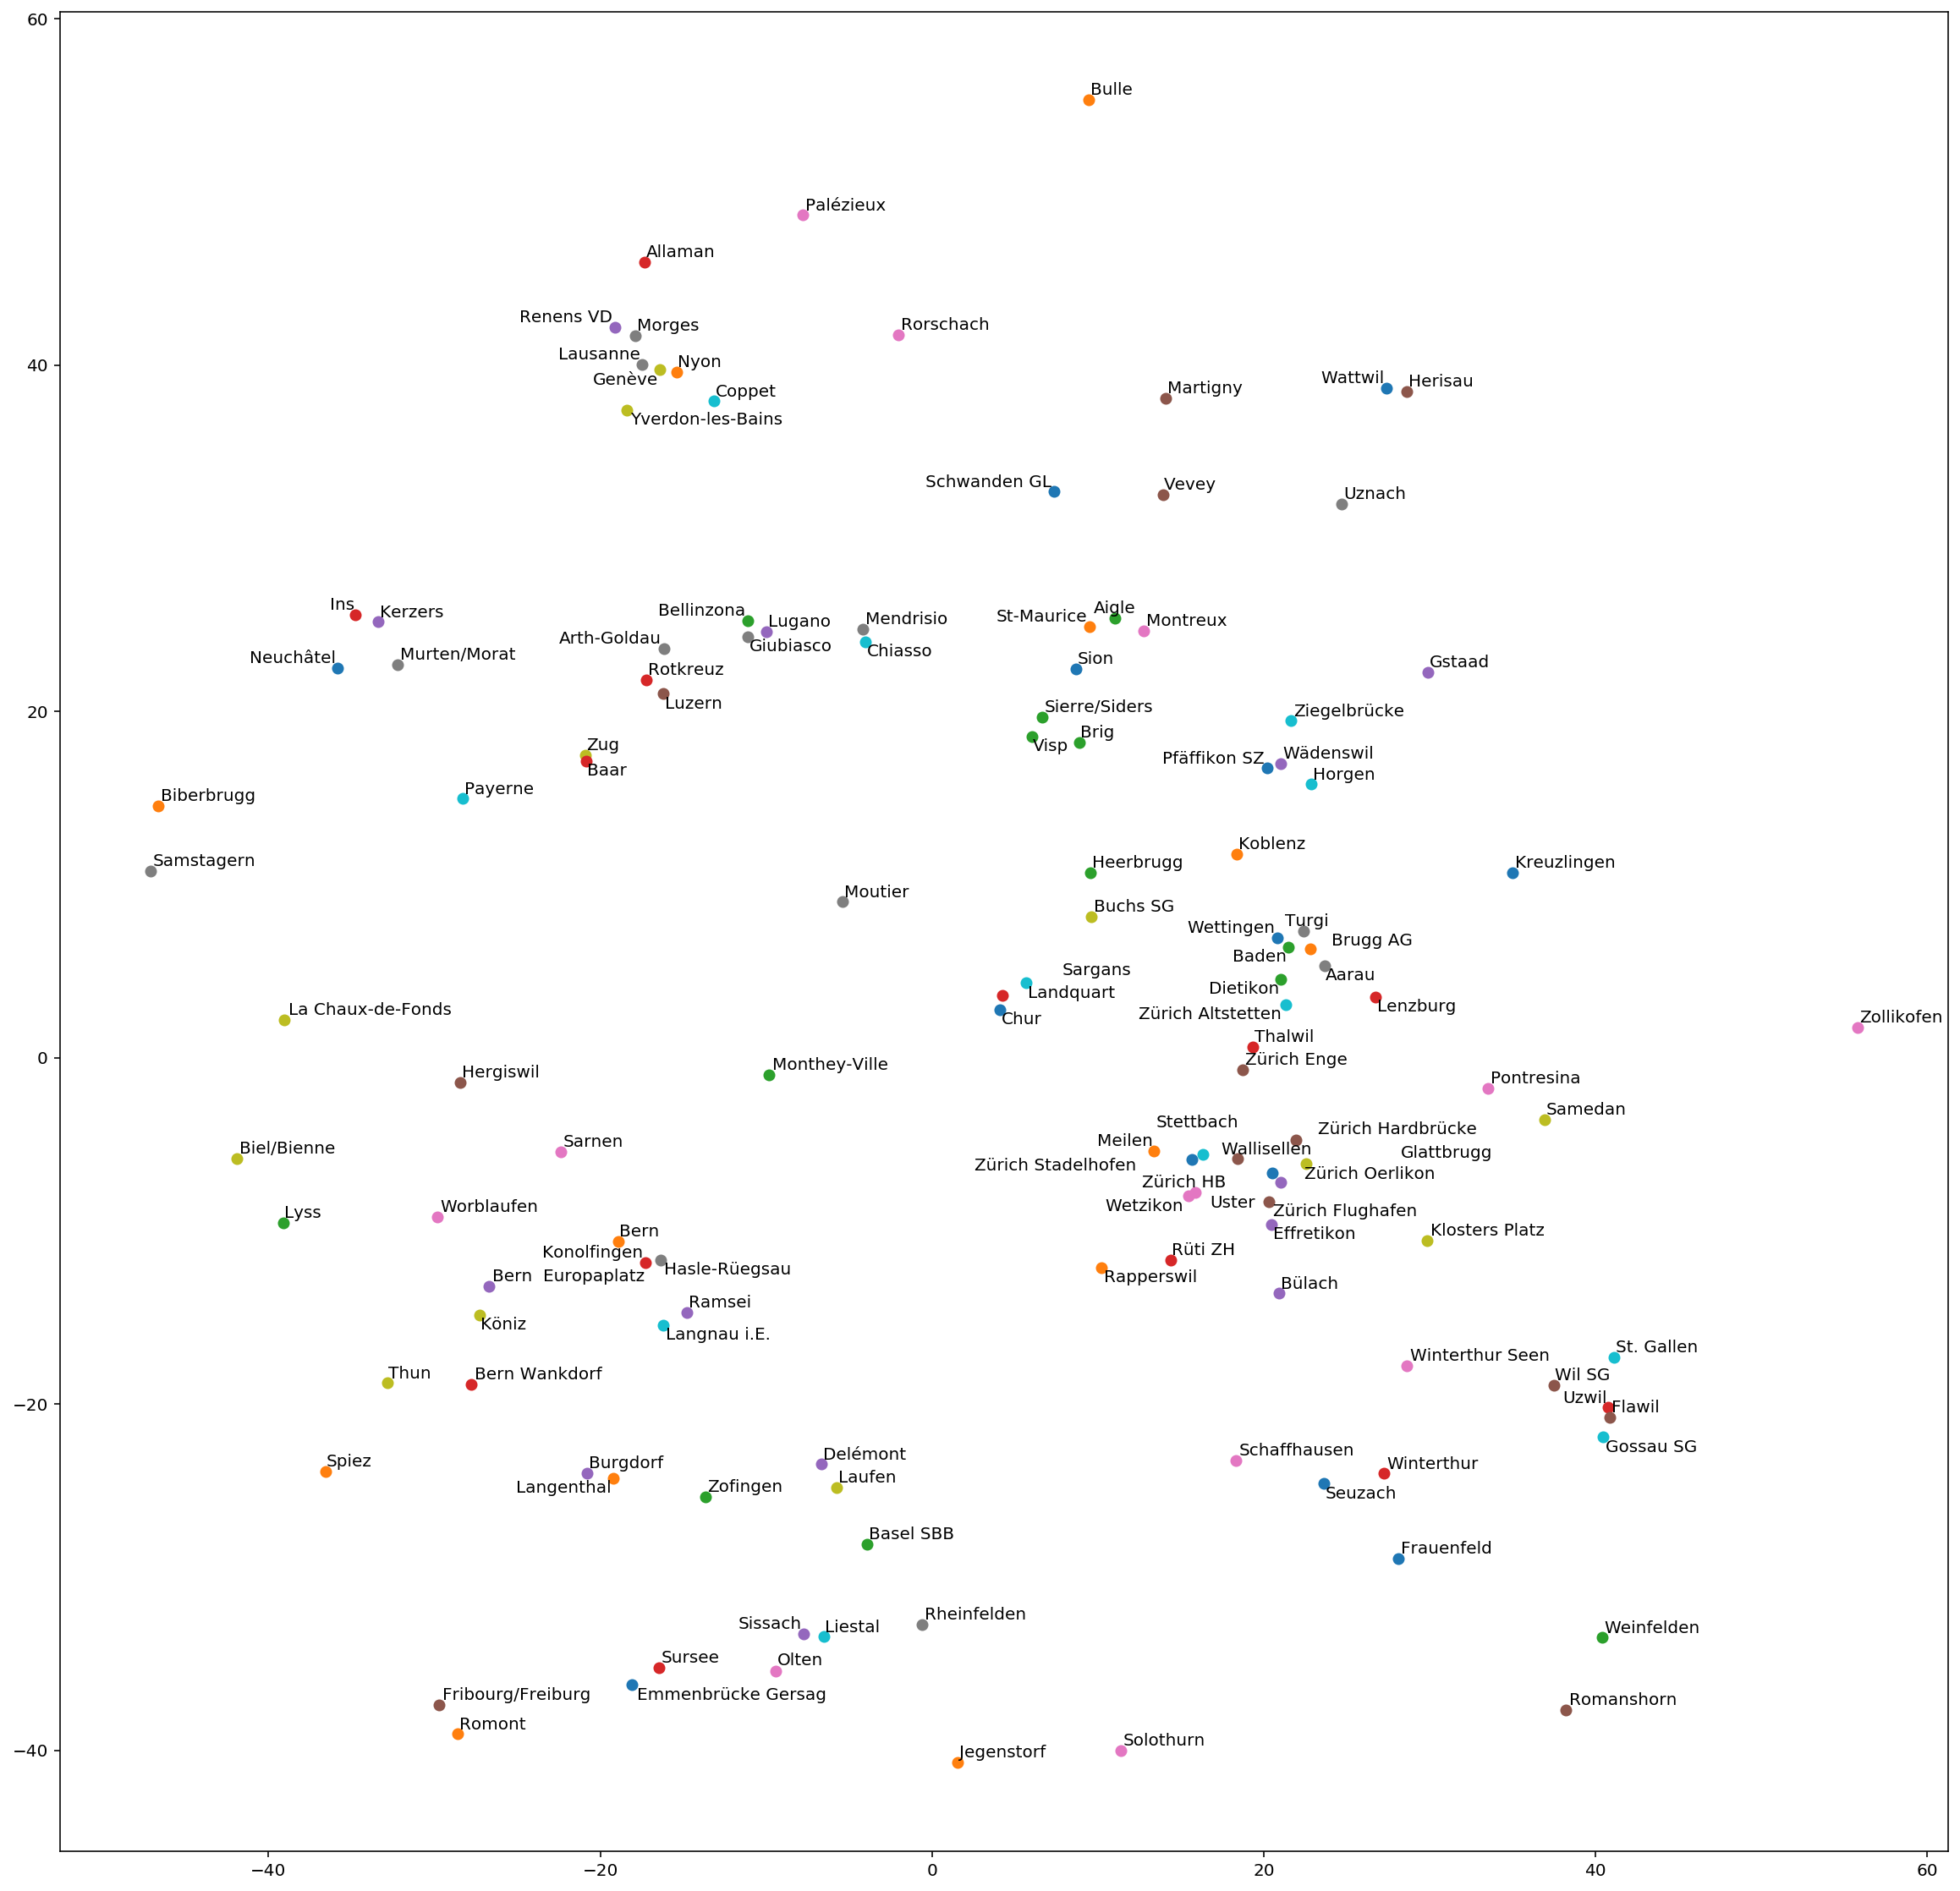

In [654]:
# TSNE visualization
texts = []
fig = plt.figure(figsize=(20, 20))  #in inches
for i, label in enumerate(labels):
    if '=>' in label or label in ['UNK', 'PAD']:
        pass
    else:
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        text = plt.text(x, y, label)
        texts.append(text)
adjust_text(texts);
path = '/home/georg/Jupyter/embeddings.jpg'
fig.savefig(path, dpi=200)

plt.show()
plt.close()

In [588]:
# Export files for visualization
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(dictionary):
    if word in ['UNK', 'PAD']:
        pass
    else:
        vec = final_embeddings[num]
        out_m.write(word + "\n")
        out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()